# SRRF ODMR Anlaysis 

The aim of this script is to take a 2D scan of a nanodiamond (or cluster in the future) and to find the fluorescence intensity for the ND by fitting a gaussian curve to the data and recording the max amplitude of the curve. From this Gaussian curve, it is possible to also extract the x and y resolution limits by looking at the FWHM of the curve. 

From here, I will also import the SRRF data for the ND in question (I have previously generated the drift table and the SRRF dataset for the image). I will then run the same program and compare the two datasets. 

The data will be saved into a text file and a secondary script will be used to analyse this data... Or I'll tag it on to the bottom of this script, I haven't decided yet. 

In [1]:
import numpy as np 
import scipy.optimize as opt 
import matplotlib.pyplot as plot 
import pandas as pd 
import skimage.feature as si
from mpl_toolkits import mplot3d

In [2]:
def get_data(file_location):
    '''Here we take the file location for the 2D dataset and 
    load it into a numpy array. '''
    
    # Open the file and read in the dataset.
    with open(file_location, 'r') as stack_2D:
        # data saved into content.
        content = stack_2D.read()
    
    # Sort data into two variables , one with the image data (scan_array)
    # and another with the meta data for the image. 
        # intialise variables. 
    image_data = []
    scan_metadata = []
    store_scan_metadata = []
    
    # ignore the first 6 lines of the array (plain text)
    lines = content.splitlines()[6:]
    for line in lines:
        # remove the "new line" text from the row. 
        row = line.split('\t')
        # Save metadata and PSF scan data in separate variables (done by length due to ease)
        # as strings
        if len(row) < 20:
            store_scan_metadata.append(row)
            continue 
        image_data.append(row[0:len(row)-1])
    
    # Extract the metadata for the scan used to create the data_set. 
    scan_metadata = np.array(store_scan_metadata[4]
                             [0:len(store_scan_metadata[4])-1]).astype(float)

    # convert the scan_array list into a float array. 
    image_array = np.array(image_data, dtype = np.float)
    
    return(image_array, scan_metadata)    

In [3]:
def generate_3D_scan_range(scan_data):
    
    x_scan = np.linspace(0, scan_data[2]-scan_data[1], int(scan_data[3]))
    y_scan = np.linspace(0, scan_data[5]-scan_data[4], int(scan_data[6]))
    z_scan = np.linspace(0, scan_data[8]-scan_data[7], int(scan_data[9]))
    
    # In python, the 3D stack shape is (z, x, y)
    psf_array_shape = [int(scan_data[9]),  int(scan_data[3]),  int(scan_data[6])]
    
    return([x_scan, y_scan, z_scan], psf_array_shape)

In [113]:
def fit_gauss(scan_data, pixel_size):
    '''fitting a gaussian to the line profiles of the x and y segments 
    that are centred around the brightest point in the sample.'''
    
    # Generate the x and y pixel line values. 
    x_range = np.linspace(0, scan_data.shape[2]-1, scan_data.shape[2])
    y_range = np.linspace(0, scan_data.shape[1]-1, scan_data.shape[1])
    
    # Initial values for the fitting params
    amp = np.max(scan_data)
    FWHM = 10
    mean_pos_x = 10

    
    p0 = [amp, mean_pos_x, FWHM]
    
    total_fluorescence = []
    fwhm = []

    for i in range(scan_data.shape[0]):
        # find the brightest point in the cropped data for each 2D image.  
        nd_loc = si.peak_local_max(scan_data[i, :, :], min_distance = 2, exclude_border = True, num_peaks = 1)[0]
        
        # fit a gaussian to each 2D image for x and y data. 
        opt_x_fit, x_conf = opt.curve_fit(gaussian, x_range, scan_data[i, nd_loc[0],:], p0)
        opt_y_fit, y_conf = opt.curve_fit(gaussian, y_range, scan_data[i, :, nd_loc[1]], p0)
        
        # Create a high resolution y fit for the gaussian curves for analysis
        high_res_pixels_x = np.linspace(0, scan_data.shape[2]-1, 10*len(scan_data[i, 0,:]))
        high_res_pixels_y = np.linspace(0, scan_data.shape[1]-1, 10*len(scan_data[i, :,0]))
    
        high_res_x_fit = gaussian(high_res_pixels_x, opt_x_fit[0], opt_x_fit[1], opt_x_fit[2])
        high_res_y_fit = gaussian(high_res_pixels_y, opt_y_fit[0], opt_y_fit[1], opt_y_fit[2])

        # Extract the FWHM from the gaussian curves. 
        fwhm_x = find_fwhm(high_res_x_fit, high_res_pixels_x, opt_x_fit)
        fwhm_y = find_fwhm(high_res_y_fit, high_res_pixels_y, opt_y_fit)
        
        
        #max_fluorescence.append( 0.5*(np.max(high_res_x_fit) + np.max(high_res_y_fit)) )
        
        # save the 2D image total fluorescence and FWHM for each 2D image. 
        total_fluorescence.append( np.sum(scan_data[i,:,:]) )
        fwhm.append( [fwhm_x, fwhm_y] )
    
    # Find the mean total fluorescence data and FWHM data. 
    total_fluorescence = np.mean(total_fluorescence)
                                 
    fwhm = np.mean(fwhm, axis = 0)*pixel_size

    return(total_fluorescence, fwhm)
    

In [5]:
def gaussian(x, amp, mean_position, FWHM):
    '''A single dimensional gaussian fitting.'''
    
    y = amp*np.exp(-(x-mean_position)**2/(2*np.power(FWHM,2)))  
    return(y)

In [6]:
def find_fwhm(y_fit, fine_x, opt_fit_y):
    '''Find the FWHM for a gaussian fit'''

    index = []
    # find the indicies for which the gaussian curve has a 
    # value greater than 1/2 the max value. 
    for i in range(len(y_fit)):
        if y_fit[i] >= opt_fit_y[0]/2:
            index.append(i)
    
    index = np.array(index)
    
    # Calculate the FWHM.
    fwhm_in_pixles = fine_x[np.max(index)] - fine_x[np.min(index)]   
    
    return(fwhm_in_pixles)

In [7]:
def get_srrf_image(srrf_image_loc):
    '''load the SRRF data into a numpy array'''
    
    srrf_image_data = np.loadtxt(srrf_image_loc)
    return(srrf_image_data)

total mean fluorescence 21203.82
[0.27135922 0.26121359]


Text(0.5, 1.0, '2D scan of the ND under study')

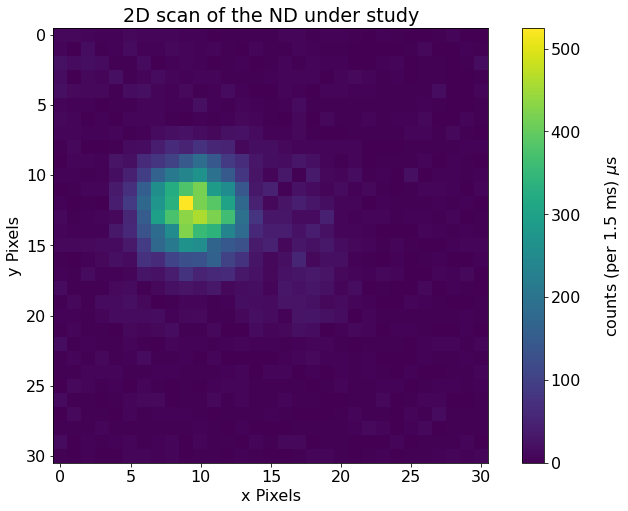

In [184]:
'''Here we start the actual running of the code for the 2D analysis.'''

folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'
date = '20210414'
file_name = '20210414_SRRF_06'

plot.rcParams.update({'font.size' : 16})
plot.rcParams.update({'figure.figsize' :[12, 8]})

# Get the scan data from the file location.
scan_data, meta_data = get_data(folder_path + date+ '\\' + file_name + '.dat')

pixel_size = (meta_data[2]-meta_data[1])/(meta_data[3]-1) # in  microns

scan_range, data_array_shape = generate_3D_scan_range(meta_data)

# reshape PSF array to 3D object. z, y, x 
scan_data = scan_data.reshape(data_array_shape[0], data_array_shape[1],
                 data_array_shape[2])

# Find the ND in the sample
nd_loc = si.peak_local_max(scan_data[0,:,:], min_distance = 5, exclude_border = True, num_peaks = 1)[0]

sub_stack = scan_data[:, nd_loc[0]-10:nd_loc[0]+10, nd_loc[0]-10:nd_loc[0]+10]

# For each of the images in the stack, find the ND.
total_fluorescence, mean_fwhm = fit_gauss(scan_data, pixel_size)

print('total mean fluorescence ' + str(total_fluorescence))
print(mean_fwhm)

plot.imshow(scan_data[0,:,:])
plot.colorbar( label = '\ncounts (per 1.5 ms)' + r' $\mu$s')
plot.xlabel('x Pixels')
plot.ylabel('y Pixels')
plot.title('2D scan of the ND under study')

In [185]:
'''Here we start the analysis of the SRRF image. '''

# Set the name of the SRRF image 
srrf_file = file_name + ' - SRRF_analysis'

# Get the SRRF image data (This has its own function as it is a text file filled with numbers. )
srrf_image = get_srrf_image(folder_path + date + '\\' + srrf_file +'.txt')

# Find the scale of the SRRF image compared to the confocal image. 
srrf_pixel_res_scale = [srrf_image.shape[0]/scan_data.shape[1], srrf_image.shape[1]/scan_data.shape[2]]
srrf_pixel_res = pixel_size/srrf_pixel_res_scale # in microns. 

# Find the ND in the sample
srrf_nd_loc = si.peak_local_max(srrf_image, min_distance = 10, exclude_border = True, num_peaks = 1)[0]

# Generate a sub-stack for analysis 
sub_srrf_stack = srrf_image[srrf_nd_loc[0]-30:srrf_nd_loc[0]+30, srrf_nd_loc[0]-30:srrf_nd_loc[0]+30]

# reshape PSF array to 3D object. z, y, x 
sub_srrf_stack = sub_srrf_stack.reshape(1, sub_srrf_stack.shape[0], sub_srrf_stack.shape[1])

srrf_image = srrf_image.reshape(1, srrf_image.shape[0], srrf_image.shape[1])

# Get the total fluorescence from the SRRF image and the FWHM for the ND in question. 
srrf_total_fluorescence, srrf_mean_fwhm = fit_gauss(srrf_image, srrf_pixel_res[0])
print(srrf_mean_fwhm)
print(srrf_total_fluorescence)

[0.04892864 0.04892864]
9.581


Text(0.5, 1.0, 'SRRF Scan of the ND under study')

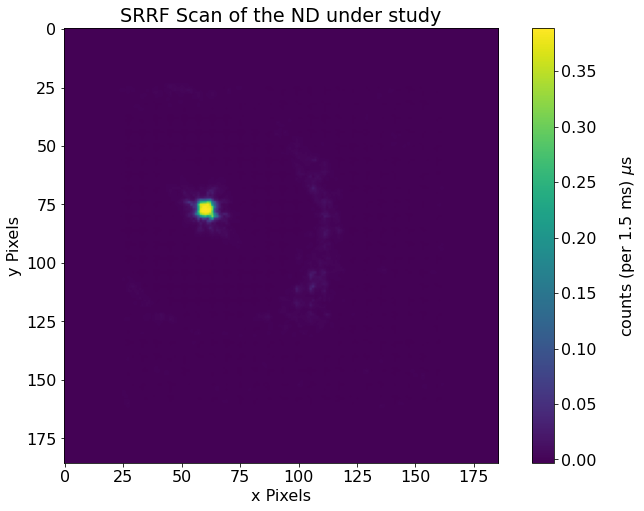

In [71]:
plot.imshow(srrf_image)
plot.colorbar( label = '\ncounts (per 1.5 ms)' + r' $\mu$s')
plot.xlabel('x Pixels')
plot.ylabel('y Pixels')
plot.title('SRRF Scan of the ND under study')

In [46]:
data.append(total_fluorescence)

In [47]:
print(data)

[18039.96, 17185.61, 18689.99, 18563.51]


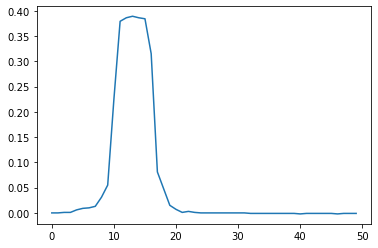

In [53]:
x = np.linspace(0, 49, 50)
plot.plot(x, sub_srrf_stack[0, 30, 0:50])

In [23]:
data = []

In [75]:
pixels = []
for i in range(50):
    if sub_srrf_stack[0, 32, i] > 0.05:
        pixels.append(i)
        
ND_size = (np.max(pixels) - np.min(pixels))*srrf_pixel_res[0]
print(ND_size)

0.075


In [82]:
# Finding the change in the totalfluorescence captured in each of the 2Dimages within the 100 image SRRF stack

total_counts, FWHM = fit_gauss(scan_data, pixel_size)
    

Text(0, 0.5, 'Total fluorescence in image')

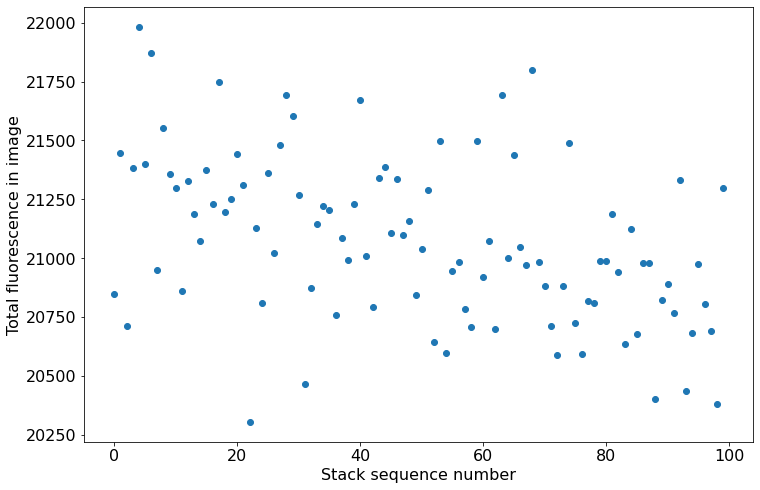

In [92]:
x = np.linspace(0, 99 , 100)
plot.scatter(x, total_counts)
plot.xlabel('Stack sequence number')
plot.ylabel('Total fluorescence in image')


16129.64


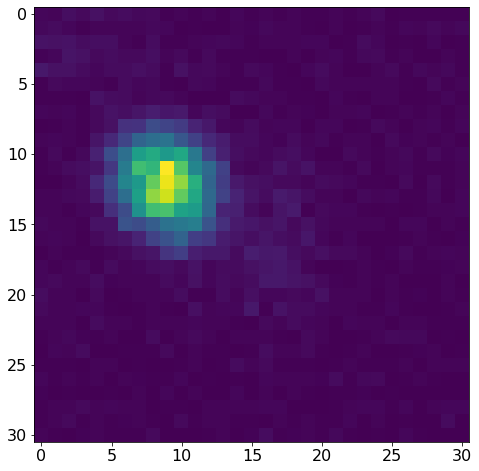

In [186]:
total_nd_fluorescence = []
for i in range(scan_data.shape[0]):
    image_frame = scan_data[i,:,:]
    y, x = np.where(image_frame > np.mean(image_frame))
    
    total_nd_fluorescence.append(np.sum(image_frame[y,x]))
print(np.mean(total_nd_fluorescence))
plot.imshow(image_frame)

17.491
8.246211251235321


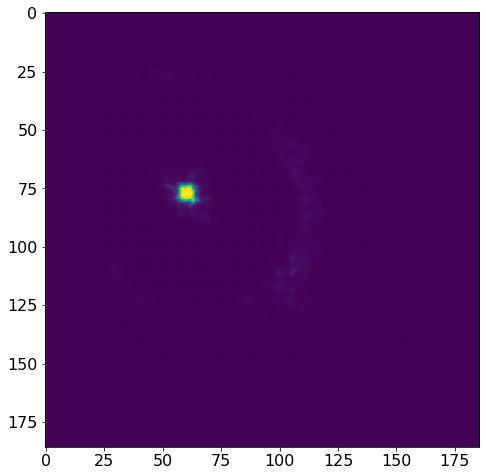

In [187]:
total_nd_SRRF_fluorescence = []
for i in range(srrf_image.shape[0]):
    image_frame = srrf_image[i,:,:]
    y, x = np.where(image_frame > 0.2*np.max(image_frame))
    
    total_nd_SRRF_fluorescence.append(np.sum(image_frame[y,x]))
print(np.mean(total_nd_SRRF_fluorescence))
plot.imshow(image_frame)
print(np.sqrt(len(y)))